In [6]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import jv
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t
from few.utils.geodesic import get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.interpolate import CubicSpline
from few import get_file_manager
from scipy.integrate import cumulative_trapezoid


In [7]:
# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1)
frequencies = data[:,0]
psd_values  = data[:, 1] ** 2
# define PSD function
get_sensitivity = CubicSpline(frequencies, psd_values)
f_plots = np.logspace(-5, 0, 2300)
#f = freq >= 0.0
#print("f, ASD, PSD:", data[10,0], np.sqrt(get_sensitivity(data[10,0])), get_sensitivity(data[10,0]))


In [8]:
def nu_naught(a):
    """
    Orbital frequency (Hz) in geometrized units where G = c = 1.
    Input:
        a : semimajor axis in geometric seconds (a = a_SI / c)
    Returns:
        nu : orbital frequency in Hz (1/s)
    """
    return (1.0 / (2.0 * np.pi)) * np.sqrt(Mtot / a**3)

In [4]:
# Physical constants - everything is in metric units
G   = 6.67430e-11 # N(m/kg)²
c   = 299792458.0 # m/s
Msun = 1.98847e30 # kg
pc   = 3.085677581491367e16 # Meters
yr   = 365.25*24*3600 # seconds

# System parameters
Mbh = 4e6 * Msun *G/c**3       # central black hole mass (kg)
m   = 0.05 * Msun  *G/c**3     # brown dwarf mass (kg)
D   = 8000 * pc /c        # Distance to GC (m)
Mtot = Mbh + m # Total mass (kg)
mu = (Mbh*m)/Mtot  # Since EMRI, probably can just be equal to m
S_spin = 0.0 # Current Approximation, aka a_star = S/M^2

# Initial orbital parameters
a0 = 0.002 * pc/c         # semi-major axis (m)
e0 = 0.999             # initial eccentricity (unitless)
#nu_0 = nu_naught(a0)     # Hz (1/s)
phi_0 = 0.0
gamma_0 = 0.0

In [5]:
plunge_radius = 8.0*Mbh

In [6]:
transition_radius = plunge_radius / 10.0 # seconds

In [7]:
def g_n_e(n, e):
    ne = n*e
    Jn_2 = jv(n-2, ne)
    Jn_1 = jv(n-1, ne)
    Jn   = jv(n,   ne)
    Jn1  = jv(n+1, ne)
    Jn2  = jv(n+2, ne)
    term1 = Jn_2 - 2*e*Jn_1 + (2.0/n)*Jn + 2*e*Jn1 - Jn2
    term2 = Jn_2 - 2*Jn + Jn2
    return (n**4/32.0) * (term1**2 + (1 - e**2)*term2**2 + (4.0/(3*n**2))*(Jn**2))


In [8]:
# Peters da/dt and de/dt (use a and e directly)
def da_dt(e, a):
    one_e2 = np.maximum(1e-16, 1 - e**2)
    e = float(np.minimum(e, 1 - 1e-16))
    a = float(np.maximum(a, plunge_radius)) # if needed
    #one_e2 = 1-e**2
    return -(64/5) * m * Mbh * Mtot / ( a**3 * one_e2**(7/2)) * (1 + (73/24)*e**2 + (37/96)*e**4)

def de_dt(e, a):
    one_e2 = np.maximum(1e-16, 1 - e**2)
    a = np.maximum(a, plunge_radius)
    e = np.minimum(e, 1 - 1e-16)
    return -(304/15) * e * m * Mbh * Mtot / (a**4 * one_e2**(5/2)) * (1 + (121/304)*e**2)


# ODE rh
def rhs(t, y):
    e, a = y
    
    return [de_dt(e, a), da_dt(e, a)]
 


In [10]:
def de_dt_val(phi, nu, gamma, e):
    mu = m * Mbh / Mtot  # reduced mass
    one_minus_e2 = max(1e-16, 1 - e**2)
    lambda_var = 0
    S = 0
    x = (2 * np.pi * Mtot * nu)  # dimensionless PN parameter
    x23 = x**(2/3)
    x83 = x**(8/3)
    x113 = x**(11/3)

    term1 = (304 + 121*e**2) * (1 - e**2) * (1 + 12*x23)
    term2 = (1/56) * x23 * (8*16705 + 12*9082*e**2 - 25211*e**4)
    first_bracket = term1 - term2

    first_part = (
        - (e / 15.0)
        * (mu / Mtot**2)
        * one_minus_e2**(-3.5)
        * x83
        * first_bracket
    )

    spin_part = (
        e * (mu / Mtot**2) * (S / Mtot**2) * np.cos(lambda_var)
        * x113 * one_minus_e2**(-4)
        * ((1364/5) + (5032/15)*e**2 + (263/10)*e**4)
    )

    return first_part + spin_part

def dphi_dt(phi, nu, gamma, e):
    return 2*np.pi*nu

def dgamma_dt(phi, nu, gamma, e):
    # Asume cos(lambda) = 1
    lambda_var = 0
    a_star = 0.0

    # Avoid division by zero
    zero_term = np.maximum(1e-16, (1-e**2))

    first_term = 6*np.pi*nu * (2*np.pi*nu*Mbh)**(2/3) * (zero_term)**(-1)
    second_term = 1 + (1/4)*(2*np.pi*nu*Mbh)**(2/3) * (zero_term)**(-1) * (26-15*e**2)
    
    # Let spin factor be S/M**2 = 0.0
    third_term = -12*np.pi*nu*np.cos(lambda_var)*(a_star)*(2*np.pi*Mbh*nu)*(zero_term)**(-3/2)
    return (first_term*second_term - third_term)

def dnu_dt(phi, nu, gamma, e):    
    lambda_var = 0
    a_star = 0.0
    zero_term = np.maximum(1e-16,(1-e**2))
    first_term = (96/(10*np.pi))*(m/(Mbh**3))*((2*np.pi*Mbh*nu)**(11/3)) * ((zero_term)**(-9/2))
    a1 = 1 + (73/24)*(e**2) + (37/96)*(e**4)
    b1 = (1273/336) - (2561/224)*(e**2) - (3885/128)*(e**4) - (13147/5376)*(e**6)
    c1 = (73/12) + (1211/24)*(e**2) + (3143/96)*(e**4) + (65/64)*(e**6)
    return first_term*(a1*(zero_term) + ((2*np.pi*Mbh*nu)**(2/3))*b1 - ((2*np.pi*Mbh*nu)*(a_star)*np.cos(lambda_var)*((zero_term)**(-1/2)))*c1)

# ODE rh
def pn_equations(t, y):
    phi, nu, gamma, e = y
    dphi = dphi_dt(phi, nu, gamma, e)
    dnu = dnu_dt(phi, nu, gamma, e)
    dgamma = dgamma_dt(phi, nu, gamma, e)
    decc = de_dt_val(phi, nu, gamma, e)
    
    return [dphi, dnu, dgamma, decc]

In [11]:
# Plunge event
def stop_plunge(t, y):
    phi, nu, gamma, e = y
    a = (Mbh/(2*np.pi*nu))**(1/3)
    return a*(1 - e) - plunge_radius
stop_plunge.terminal = True
stop_plunge.direction = -1

In [12]:
# Plunge event
def stop_transition(t, y):
    e, a = y
    return a*(1 - e) - transition_radius
stop_transition.terminal = True
stop_transition.direction = -1

In [23]:
# Integrate
t_initial = 1e15 # 3.17 x 10^7 years but integrate from "now aka zero" until "then"

sol_peters = solve_ivp(rhs, [0, t_initial], [e0,a0], method='Radau', events=stop_transition,
                rtol=1e-9, atol=1e-12, max_step=1e11)
if sol_peters.status == 1 and len(sol_peters.t_events[0])>0:
    print("Plunge event at t =", sol_peters.t_events[0][0], "s")

t_arr = sol_peters.t
time_to_plunge = abs((t_arr[-1] - t_arr) / yr)
#phi_arr = sol.y[0]
#nu_arr = sol.y[1]   # e is second
#gamma_arr = sol.y[2]
e_arr = sol_peters.y[0]
a_arr = sol_peters.y[1]
t_transition = sol_peters.t[-1]

e_transition = sol_peters.y[0, -1]
a_transition = sol_peters.y[1, -1]
#t_arr = sol_peters.t[-1]
#'''

Plunge event at t = 222591667487636.75 s


In [25]:
nu_0 = nu_naught(a_transition)
y0 = [phi_0, nu_0, gamma_0, e_transition]

In [27]:
sol_pn = solve_ivp(pn_equations, [t_transition, t_initial],
                   y0,
                   events=stop_plunge, rtol=1e-9, atol=1e-9)


In [35]:
t_full = np.concatenate((sol_peters.t, sol_pn.t))
nu_full = np.concatenate((orbital_frequency_keplerian(sol_peters.y[1]), sol_pn.y[1]))
e_full = np.concatenate((sol_peters.y[0], sol_pn.y[3]))


In [71]:
a_full = a = (Mbh/(2*np.pi*nu_full))**(1/3)

In [37]:
time_to_plunge = abs(((t_full[-1] - t_full) / yr))

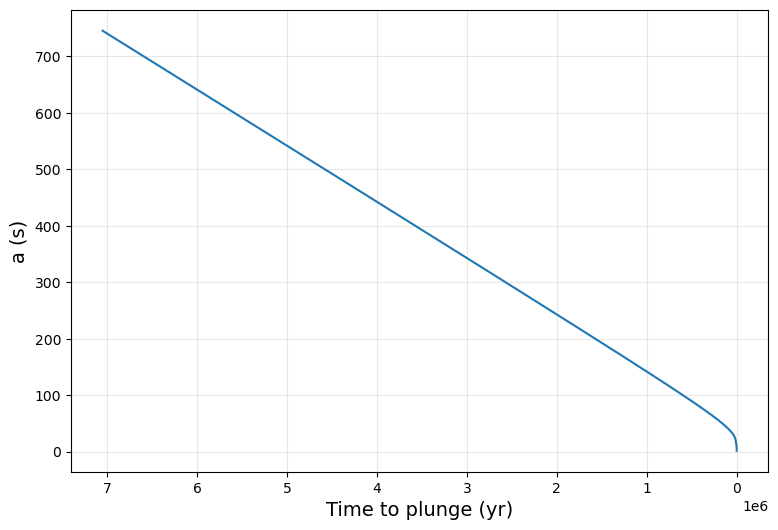

In [79]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, a_full)
plt.xlabel("Time to plunge (yr)",fontsize=14)
plt.ylabel("a (s)",fontsize=14)
#plt.xscale('log')
#lt.yscale('log')
plt.grid(True, which='both', alpha=0.3)

plt.gca().invert_xaxis()
plt.show()

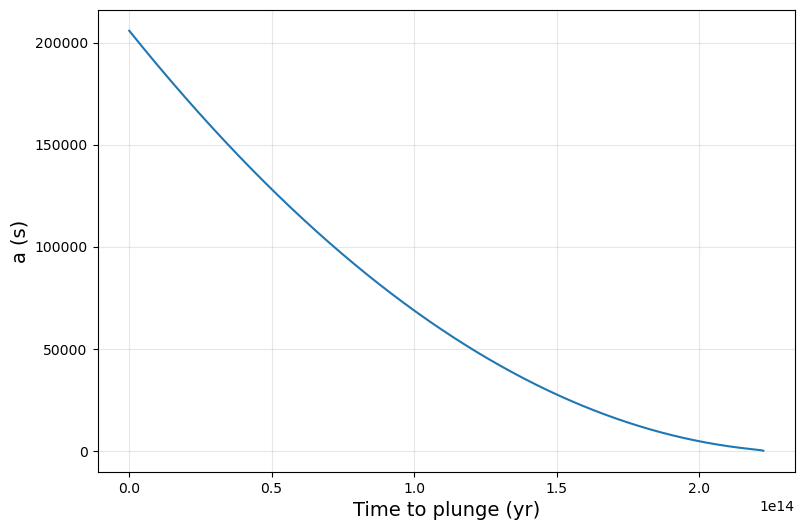

In [81]:
plt.figure(figsize=(9,6))
plt.plot(t_arr, a_arr)
plt.xlabel("Time to plunge (yr)",fontsize=14)
plt.ylabel("a (s)",fontsize=14)
#plt.xscale('log')
#lt.yscale('log')
plt.grid(True, which='both', alpha=0.3)

#plt.gca().invert_xaxis()
plt.show()

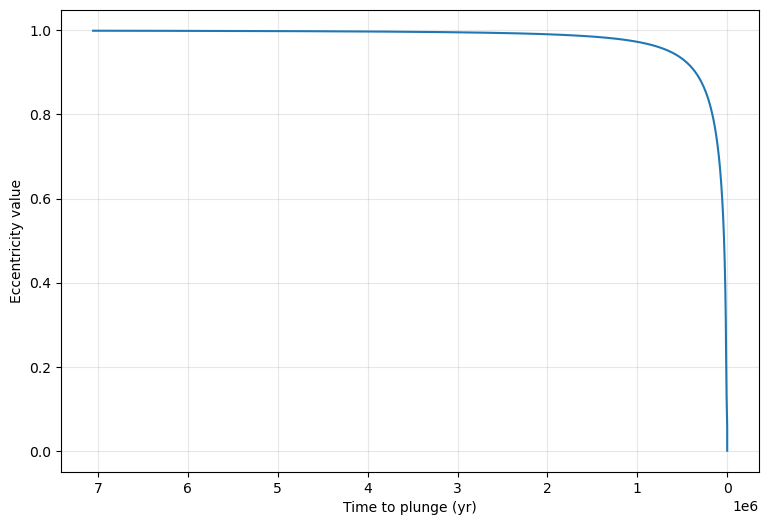

In [43]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, e_full)
plt.xlabel("Time to plunge (yr)")
plt.ylabel("Eccentricity value")
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

In [45]:
def orbital_frequency_keplerian(a): # Returns Hz
    f_o = 1/(2*np.pi) * (Mtot/(a**3))**(1/2)
    return f_o

In [47]:
f_orb_arr = orbital_frequency_keplerian(a_arr)

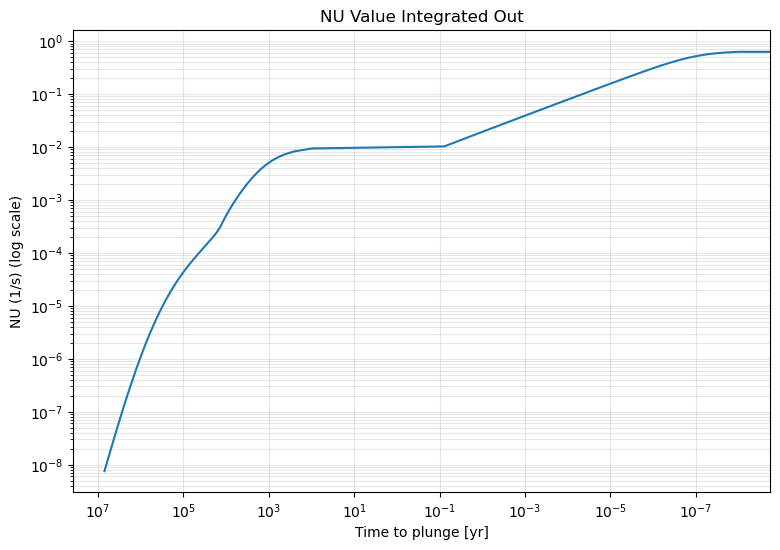

In [49]:
plt.figure(figsize=(9,6))
plt.loglog(time_to_plunge, nu_full)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("NU (1/s) (log scale)")
plt.title("NU Value Integrated Out")
#plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

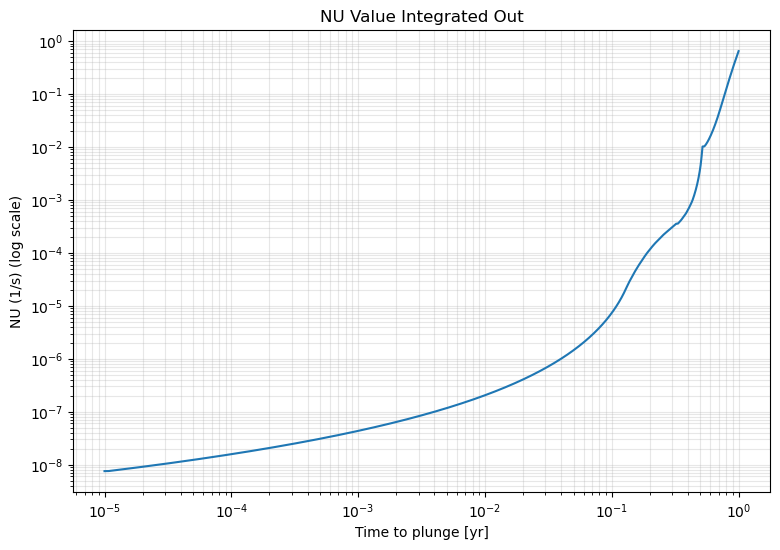

In [51]:
plt.figure(figsize=(9,6))
plt.loglog(np.logspace(-5, 0, len(nu_full)), nu_full)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("NU (1/s) (log scale)")
plt.title("NU Value Integrated Out")
#plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
#plt.gca().invert_xaxis()
plt.show()

In [375]:
f_plots = np.logspace(-4, -1, 500)

In [150]:
# Orbital Frequency vs Eccentricity
f_orbital =  []
for i in range(11):
    f_orbital.append(i*orbital_frequency(a_arr))


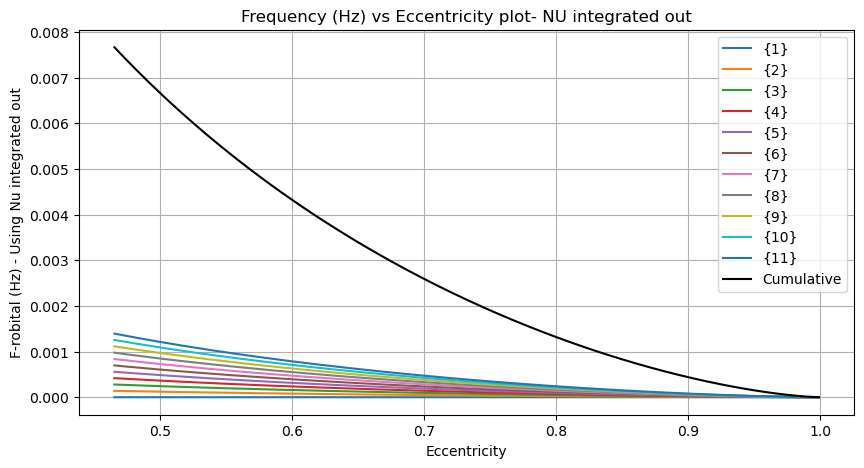

In [152]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot(e_arr, f_orbital[i], label={i+1})
plt.plot(e_arr, np.sum(f_orbital[:11], axis=0), label="Cumulative", color = 'black')
plt.xlabel("Eccentricity")
plt.ylabel("F-robital (Hz) - Using Nu integrated out")
#plt.yscale('log')
plt.title("Frequency (Hz) vs Eccentricity plot- NU integrated out")
plt.legend()
#plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

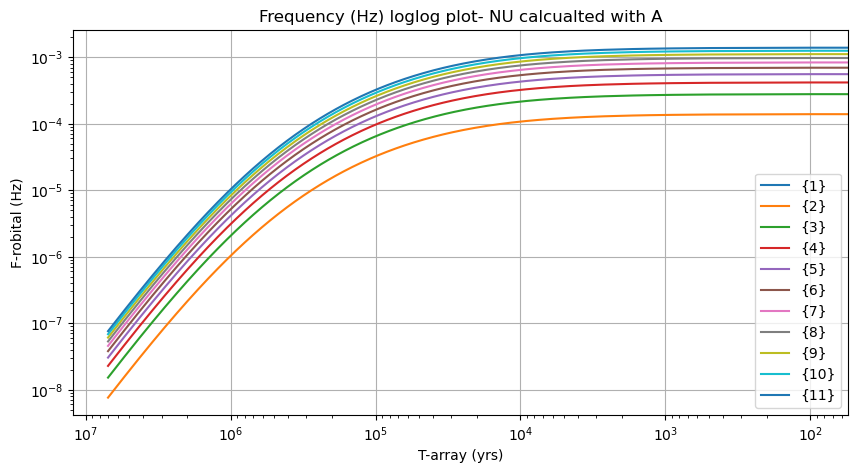

In [429]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.loglog(time_to_plunge, f_orbital[i], label={i+1})
plt.xlabel("T-array (yrs)")
plt.ylabel("F-robital (Hz)")
plt.title("Frequency (Hz) loglog plot- NU calcualted with A")
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [101]:
# Given a in meters, G in m^3 kg^-1 s^-2, mass in kg, c in m/s, D in meters this returns unitless !!
def h_c_n(n, a, e): 
    return g_n_e(n, e) * Mbh* m / (D * a)

In [107]:
h_c_n_arr = []
for i in range(1000):
    h_c_n_arr.append(h_c_n(i+1, a_arr, e_arr))

ValueError: x and y must have same first dimension, but have shapes (2656,) and (2505,)

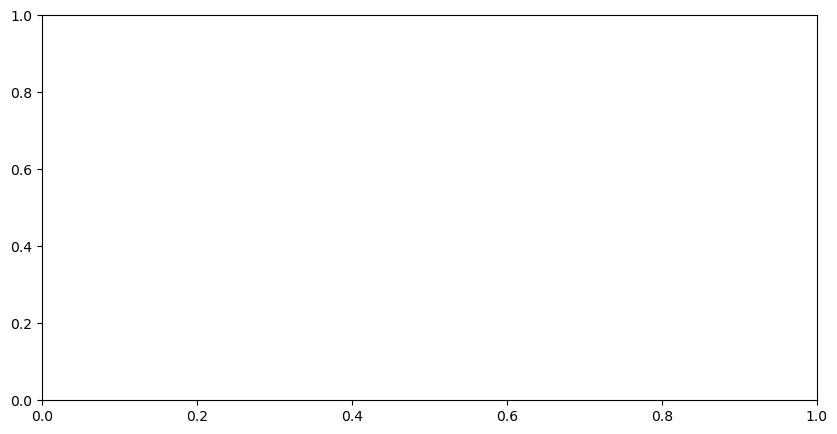

In [56]:
plt.figure(figsize=(10,5))
#for i in range(1000):
#    plt.plot(time_to_plunge, h_c_n_arr[i])#, label={i+1})
plt.plot(time_to_plunge, np.sum(h_c_n_arr[:1000], axis=0), label="Cumulative", color = 'black')
plt.yscale('log')
plt.xlabel("Time to Plunge (yr)")
plt.ylabel("Characteristic Strain (log scale unitless)")
plt.gca().invert_xaxis()
plt.title("Characteristic Strain $H_n$")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
#for i in range(1000):
    #plt.plot(f_plots, h_c_n_arr[i], label={i+1})
plt.loglog(f_plots, np.sum(h_c_n_arr[:1000], axis=0), label="Cumulative", color = 'black')
plt.loglog(f_plots, np.sqrt(S_FEW), color = 'blue', label = 'FEW Waveform')
#plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain (log scale unitless)")
#plt.gca().invert_xaxis()
plt.title("Characteristic Strain $H_n$")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
n_harmonics = 1000

In [63]:
def SN_FEW(f):
    return get_sensitivity(f)


In [65]:
S_FEW = SN_FEW(f_plots)

In [85]:
snr_of_n_of_t = np.zeros((n_harmonics, len(t_full)))

In [ ]:
for n in range(1, n_harmonics):
    for i, t0 in enumerate(t_full):
        mask = (t_full >= t0) & (t_full <= t0 + yr)
        
        t_0_arr = t_full[mask]
        a_0_arr = a_full[mask]
        e_0_arr = e_full[mask]
        print(t_0_arr.shape)
        print(a_0_arr.shape)
        print(e_0_arr.shape)
        
        #f_n = n*orbital_frequency(a_0_arr)
        f_n = n*nu_full[mask]
       
        hcn = h_c_n(n, a_0_arr, e_0_arr)
        print(hcn.shape)
        h_det = np.sqrt(SN_FEW(f_n))
        integrand = (hcn/h_det)**2/f_n
        snr_of_n_of_t[n,i] = np.trapz(integrand, f_n)

(13,)
(13,)
(13,)
(13,)
(12,)
(12,)
(12,)
(12,)
(11,)
(11,)
(11,)
(11,)
(10,)
(10,)
(10,)
(10,)
(9,)
(9,)
(9,)
(9,)
(8,)
(8,)
(8,)
(8,)
(7,)
(7,)
(7,)
(7,)
(6,)
(6,)
(6,)
(6,)
(5,)
(5,)
(5,)
(5,)
(4,)
(4,)
(4,)
(4,)
(3,)
(3,)
(3,)
(3,)
(2,)
(2,)
(2,)
(2,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)

In [437]:
snr_total_test = np.zeros(n_harmonics)
for n in range(1, n_harmonics):
    f_n = n*orbital_frequency(a_arr)
    hcn = h_c_n(n, a_arr, e_arr)
    h_det = np.sqrt(SN_FEW(f_n))
    integrand = (hcn/h_det)**2 / (f_n)
    snr_total_test[n] = np.trapz(integrand, f_n)

In [173]:
# Check units of orbital frequency
#f_orb = orbital_frequency(a_arr)  # should be in Hz
print("Orbital frequency:")
print(f" min: {np.min(nu_full):.3e} Hz, max: {np.max(nu_full):.3e} Hz")


Orbital frequency:
 min: 7.564e-09 Hz, max: 6.471e-01 Hz


In [542]:
# Check magnitude of characteristic strain
n_test = 1
hcn_test = h_c_n(n_test, a_arr, e_arr)
print("Characteristic strain h_c_n:")
print(f" min: {np.min(hcn_test):.3e}, max: {np.max(hcn_test):.3e}")


Characteristic strain h_c_n:
 min: 9.270e-25, max: 5.225e-22


In [544]:
h_det_test = np.sqrt(SN_FEW(f_orb))
print("Detector h_det:")
print(f" min: {np.min(h_det_test):.3e}, max: {np.max(h_det_test):.3e}")


Detector h_det:
 min: 2.474e-17, max: 5.341e-13


In [546]:
integrand_test = (hcn_test / h_det_test)**2 / f_orb
print("Integrand stats:")
print(f" min: {np.min(integrand_test):.3e}, max: {np.max(integrand_test):.3e}, mean: {np.mean(integrand_test):.3e}")


Integrand stats:
 min: 3.982e-16, max: 3.131e-06, mean: 2.347e-08


In [548]:
snr_test = np.trapz(integrand_test, f_orb)
print(f"SNR for harmonic n={n_test}: {snr_test:.3e}")


SNR for harmonic n=1: 7.531e-11
